In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

(938, 473, 3)


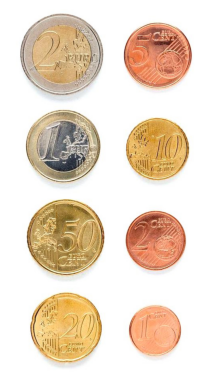

In [2]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Text(0.5, 1.0, 'FIJO invertida')

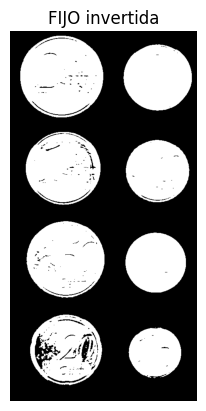

In [3]:
#Convertimos la imagen a escala de grises
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar un blur para reducir ruido
img_blur = cv2.GaussianBlur(img_gris, (5,5), 0)
# Luego aplicar Otsu
th, img_th1 = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')


Text(0.5, 1.0, 'Externos')

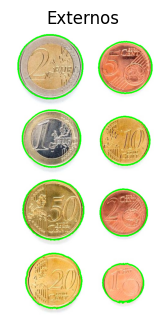

In [4]:
# Comenzamos la detección de contornos
#Obtiene únicamente los contornos externos
contornos, hierarchy1 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

In [5]:
# --- Tabla de diámetros de monedas en mm ---
monedas_mm = {
    "1 centimo": 16.25,
    "2 centimos": 18.75,
    "5 centimos": 21.25,
    "10 centimos": 19.75,
    "20 centimos": 22.25,
    "50 centimos": 24.25,
    "1 euro": 23.25,
    "2 euros": 25.75,
}

monedas_valor = {
    "1 centimo": 0.01, "2 centimos": 0.02, "5 centimos": 0.05,
    "10 centimos": 0.10, "20 centimos": 0.20, "50 centimos": 0.50,
    "1 euro": 1.00, "2 euros": 2.00
}

# Guardar círculos detectados [(x, y, radio)]
circulos = []
for c in contornos:
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)
    circularidad = 4 * np.pi * area / (perimetro**2 + 1e-5)
    if circularidad < 0.5:
        continue
    (x, y), r = cv2.minEnclosingCircle(c)
    circulos.append((int(x), int(y), r))

# --- Variables globales ---
escala = None  # px/mm
referencia_seleccionada = False

# --- Función callback para ratón ---
def click_event(event, x, y, flags, param):
    global escala, referencia_seleccionada
    if event == cv2.EVENT_LBUTTONDOWN:
        # Buscar círculo más cercano al clic
        for (cx, cy, r) in circulos:
            if (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2:
                # Usar este círculo como referencia
                radio_ref_pix = r
                diametro_ref_mm = 23.25  # asumimos que es 1 €
                escala = (2 * radio_ref_pix) / diametro_ref_mm
                referencia_seleccionada = True
                print(f"Moneda de referencia seleccionada en ({cx},{cy}), radio {r:.2f}px")
                break

cv2.namedWindow("Monedas")
cv2.setMouseCallback("Monedas", click_event)

while True:
    display = img.copy()

    # Dibujar contornos
    for (cx, cy, r) in circulos:
        cv2.circle(display, (cx, cy), int(r), (0, 255, 0), 2)
        cv2.circle(display, (cx, cy), 2, (0, 0, 255), -1)

    if referencia_seleccionada and escala is not None:
        conteo = {}
        valor_total = 0.0

        for (cx, cy, r) in circulos:
            diametro_mm = (2 * r) / escala

            # Clasificar moneda: la más cercana en diámetro
            mejor_moneda = min(monedas_mm.keys(),
                               key=lambda m: abs(monedas_mm[m] - diametro_mm))

            # Acumular conteo y valor
            conteo[mejor_moneda] = conteo.get(mejor_moneda, 0) + 1
            valor_total += monedas_valor[mejor_moneda]

            # Etiquetar en imagen
            cv2.putText(display, mejor_moneda, (cx - 40, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

        cv2.putText(display, f"Total: {valor_total:.2f} euros",
                    (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

    cv2.imshow("Monedas", display)

    if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

Moneda de referencia seleccionada en (133,346), radio 94.64px


-1

1. Extrayendo características de entrenamiento (Múltiples muestras por clase)...
Total de muestras de entrenamiento extraídas: 313

2. Iniciando Optimización automática (Grid Search) para el clasificador k-NN (CON PESOS MANUALES)...
   - Optimización completada.
   - Mejor Exactitud (Validación Cruzada): 0.6330
   - Mejores Parámetros encontrados: {'metric': <function weighted_euclidean_distance at 0x12c39fc40>, 'n_neighbors': 9, 'weights': 'uniform'}

3. Clasificando muestras de prueba con el modelo optimizado...

Número total de muestras clasificadas: 97 / 97

4. Calculando Métricas Finales...
Accuracy (Exactitud) FINAL: 0.4845
Precision (Precisión): 0.4695
Recall (Sensibilidad): 0.4845
F1 Score: 0.4554


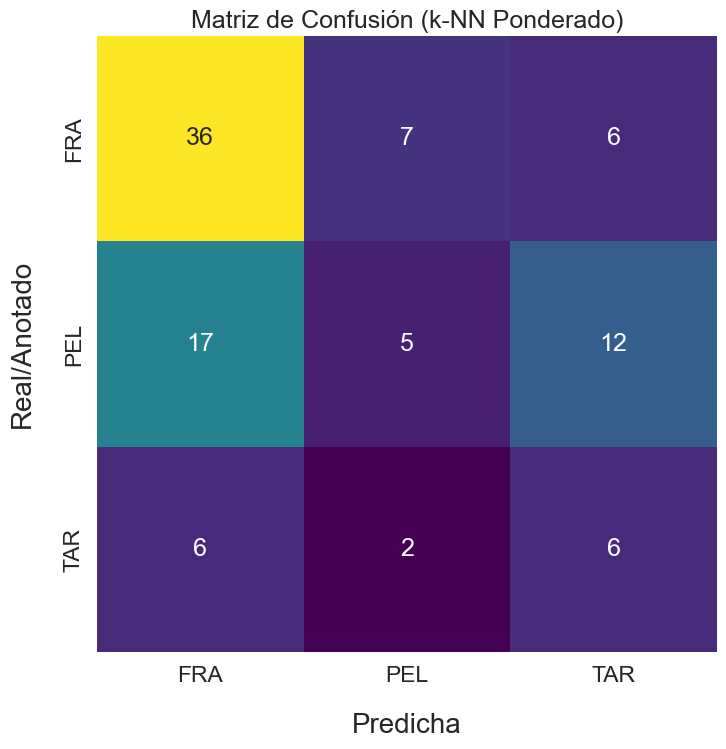

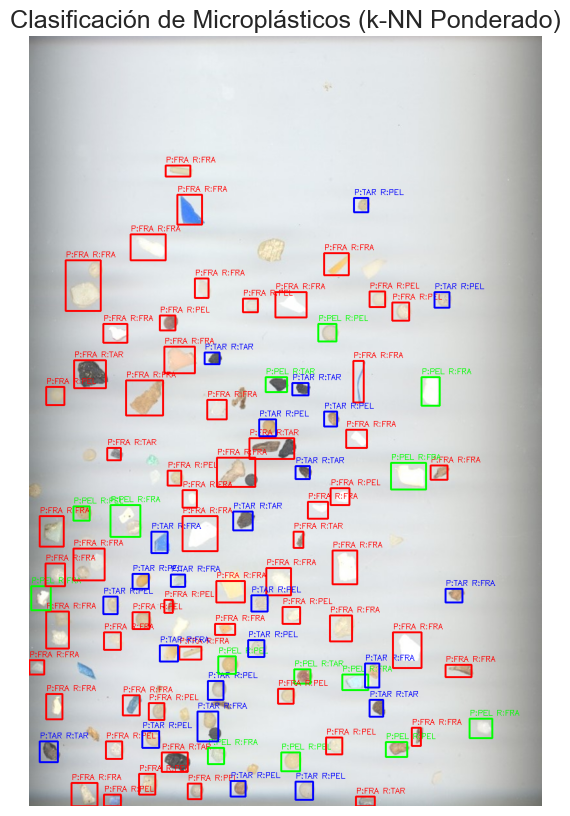

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler # Usamos MinMaxScaler para el rango [0, 1]
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean, cdist # Importamos cdist para la distancia personalizada

# ==============================================================================
# 1. FUNCIONES DE EXTRACCIÓN Y PROCESAMIENTO
# ==============================================================================

def extract_features(contour, roi_area):
    """Extrae las 7 características geométricas solicitadas de un contorno."""
    
    # 1. Área en píxeles (Area_Px)
    area = cv2.contourArea(contour)
    
    # 2. Perímetro en píxeles (Perimeter_Px)
    perimeter = cv2.arcLength(contour, True)
    
    # 3. Compacidad: P^2 / A
    compacidad = (perimeter ** 2) / area if area != 0 else 0
    
    # Bounding Box (contenedor)
    x, y, w, h = cv2.boundingRect(contour)
    
    # 4. Relación del área de la partícula con la del contenedor (Area_Ratio_Cont)
    area_bbox = w * h
    area_ratio_cont = area / area_bbox if area_bbox != 0 else 0
    
    # 5. Relación del ancho y el alto del contenedor (AR - Aspect Ratio BBox)
    aspect_ratio_bbox = w / h if h != 0 else 0
    
    # 6. Relación entre los ejes de la elipse ajustada (ER - Ellipse Ratio)
    elipse_ratio = 0.0
    if len(contour) >= 5:
        try:
            elipse = cv2.fitEllipse(contour)
            (center, axes, orientation) = elipse
            major_axis = max(axes)
            minor_axis = min(axes)
            elipse_ratio = major_axis / minor_axis if minor_axis != 0 else 0.0
        except:
            pass # Si fitEllipse falla, usamos 0.0
    
    # 7. Relación entre las distancias menor y mayor al contorno desde el centroide (Centroid_Dist_Ratio)
    centroid_ratio = 0.0
    if area > 0:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00']) 
            cy = int(M['m01']/M['m00']) 
            
            distances = [euclidean((cx, cy), point[0]) for point in contour]
            
            if distances:
                min_dist = min(distances)
                max_dist = max(distances)
                centroid_ratio = min_dist / max_dist if max_dist != 0 else 0.0
            
    return [area, perimeter, compacidad, area_ratio_cont, aspect_ratio_bbox, elipse_ratio, centroid_ratio]

def process_training_image_robust(image_path, label):
    """Carga, segmenta y extrae características de MÚLTIPLES contornos."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Advertencia: No se pudo cargar la imagen {image_path}")
        return []
        
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features_list = []
    MIN_AREA = 90
    
    for c in contours:
        area_c = cv2.contourArea(c)
        if area_c > MIN_AREA:
            x, y, w, h = cv2.boundingRect(c)
            # Pasamos el área del BBox (w*h) como contenedor
            features = extract_features(c, w * h) 
            features_list.append(features + [label])
            
    return features_list

FEATURE_NAMES = ['Area_Px', 'Perimeter_Px', 'Compacidad', 'Area_Ratio_Cont', 
                 'AR_BBox', 'ER_Ellipse', 'Centroid_Dist_Ratio']

# ==============================================================================
# DEFINICIÓN DE PESOS MANUALES Y FUNCIÓN DE DISTANCIA PONDERADA
# ==============================================================================

MANUAL_WEIGHTS = np.array([
    0.5, # 1. Area_Px
    0.5, # 2. Perimeter_Px
    2.0, # 3. Compacidad  <- Mayor peso
    1.0, # 4. Area_Ratio_Cont
    1.5, # 5. AR_BBox
    2.0, # 6. ER_Ellipse  <- Mayor peso
    1.0  # 7. Centroid_Dist_Ratio
])

def weighted_euclidean_distance(u, v):
    """
    Calcula la Distancia Euclidiana Ponderada entre dos vectores (u y v).
    d_w(u, v) = sqrt( SUM[ w_i * (u_i - v_i)^2 ] )
    """
    global MANUAL_WEIGHTS
    # Asegúrate de que los pesos tienen la dimensión correcta
    if u.shape[-1] != len(MANUAL_WEIGHTS):
        raise ValueError("El número de pesos no coincide con el número de características.")
        
    # La función cdist requiere que la métrica personalizada maneje vectores 1D
    # Si la función es usada directamente por el clasificador, u y v son 1D.
    # d(u,v) = sqrt(w * (u-v)^2).sum()
    distance = np.sqrt(np.sum(MANUAL_WEIGHTS * (u - v)**2))
    return distance


# ==============================================================================
# 2. ENTRENAMIENTO ROBUSO Y NORMALIZACIÓN (Min-Max)
# ==============================================================================

print("1. Extrayendo características de entrenamiento (Múltiples muestras por clase)...")

train_data = []
train_data.extend(process_training_image_robust('FRA.JPG', 'FRA'))
train_data.extend(process_training_image_robust('PEL.JPG', 'PEL'))
train_data.extend(process_training_image_robust('TAR.JPG', 'TAR'))

df_train = pd.DataFrame(train_data, columns=FEATURE_NAMES + ['Label'])
X_train = df_train[FEATURE_NAMES].values
y_train = df_train['Label'].values

print(f"Total de muestras de entrenamiento extraídas: {len(X_train)}")

# Normalización Min-Max [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ==============================================================================
# 3. OPTIMIZACIÓN Y ENTRENAMIENTO AUTOMÁTICO (Grid Search)
# ==============================================================================

print("\n2. Iniciando Optimización automática (Grid Search) para el clasificador k-NN (CON PESOS MANUALES)...")

# Definir el espacio de hiperparámetros a explorar
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  
    'weights': ['uniform', 'distance'], 
    # Usamos nuestra métrica de distancia personalizada con los pesos manuales
    'metric': [weighted_euclidean_distance] 
}


grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    n_jobs=-1 
)

# Entrenar el clasificador con la búsqueda en cuadrícula
grid_search.fit(X_train_scaled, y_train)

# El mejor modelo encontrado se convierte en nuestro clasificador
classifier = grid_search.best_estimator_

print("   - Optimización completada.")
print(f"   - Mejor Exactitud (Validación Cruzada): {grid_search.best_score_:.4f}")
print(f"   - Mejores Parámetros encontrados: {grid_search.best_params_}")


# ==============================================================================
# 4. CLASIFICACIÓN DE DATOS DE PRUEBA
# ==============================================================================

print("\n3. Clasificando muestras de prueba con el modelo optimizado...")

csv_file = "MPs_test_bbs.csv"
try:
    df_test = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: No se encontró el archivo {csv_file}. Creando DataFrame vacío.")
    df_test = pd.DataFrame(columns=['x_min', 'y_min', 'x_max', 'y_max', 'label'])
    
df_test['Prediction'] = ''
y_true = df_test['label'].tolist()
y_pred = []
img_test = cv2.imread('MPs_test.jpg')
img_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

# Clasificar cada partícula en la imagen de prueba
for index, row in df_test.iterrows():
    x_min, y_min, x_max, y_max = map(int, [row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    roi = img_gray[y_min:y_max, x_min:x_max]
    prediction = 'N/A'
    
    if roi.size > 0 and x_max > x_min and y_max > y_min:
        try:
            # Segmentación local
            roi_blur = cv2.medianBlur(roi, 5) 
            _, thresh_roi = cv2.threshold(roi_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                c = max(contours, key=cv2.contourArea)
                features = extract_features(c, roi.size)
                
                # Normalización (debe ser 2D para el clasificador)
                features_np = np.array(features).reshape(1, -1)
                features_scaled = scaler.transform(features_np)
                
                # Predicción con el modelo optimizado
                prediction = classifier.predict(features_scaled)[0]

        except Exception as e:
            pass # Ignorar fallos de procesamiento en una ROI
    
    df_test.loc[index, 'Prediction'] = prediction
    y_pred.append(prediction)
        
# Filtrado de muestras no clasificadas ('N/A')
y_true_final = [y_true[i] for i, p in enumerate(y_pred) if p != 'N/A']
y_pred_final = [p for p in y_pred if p != 'N/A']

print(f"\nNúmero total de muestras clasificadas: {len(y_pred_final)} / {len(y_true)}")

# ==============================================================================
# 5. EVALUACIÓN Y VISUALIZACIÓN
# ==============================================================================
print("\n4. Calculando Métricas Finales...")

# Métricas
if y_true_final:
    accuracy = accuracy_score(y_true_final, y_pred_final)
    precision = precision_score(y_true_final, y_pred_final, average='weighted', zero_division=0)
    recall = recall_score(y_true_final, y_pred_final, average='weighted', zero_division=0)
    f1score = f1_score(y_true_final, y_pred_final, average='weighted', zero_division=0)

    print(f"Accuracy (Exactitud) FINAL: {accuracy:.4f}")
    print(f"Precision (Precisión): {precision:.4f}")
    print(f"Recall (Sensibilidad): {recall:.4f}")
    print(f"F1 Score: {f1score:.4f}")

    # Matriz de Confusión
    classes = sorted(list(set(y_true)))
    conf_matrix = confusion_matrix(y_true_final, y_pred_final, labels=classes)

    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.5)
    ax = sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cbar=False, 
        cmap='viridis', 
        xticklabels=classes, 
        yticklabels=classes
    )

    ax.set_xlabel("Predicha", labelpad=20, fontsize=20)
    ax.set_ylabel("Real/Anotado", labelpad=20, fontsize=20)
    plt.title("Matriz de Confusión (k-NN Ponderado)", fontsize=18)
    plt.show()

# 6. VISUALIZACIÓN DE ANOTACIONES Y PREDICCIONES
colores_bgr = {
    "FRA": (0, 0, 255),   # Rojo (BGR)
    "PEL": (0, 255, 0),   # Verde (BGR)
    "TAR": (255, 0, 0),   # Azul (BGR)
    'N/A': (128, 128, 128) # Gris 
}

img_pred = cv2.imread('MPs_test.jpg')

for index, row in df_test.iterrows():
    etiqueta_real = row["label"]
    etiqueta_predicha = row["Prediction"] if row["Prediction"] else 'N/A'
    x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
    
    color_pred = colores_bgr.get(etiqueta_predicha, (0, 0, 0)) 
    
    cv2.rectangle(img_pred, (x_min, y_min), (x_max, y_max), color_pred, 2)
    
    text = f"P:{etiqueta_predicha} R:{etiqueta_real}"
    cv2.putText(img_pred, text, (x_min, y_min - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_pred, 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
plt.title("Clasificación de Microplásticos (k-NN Ponderado)")
plt.axis('off')
plt.show()